# U-Net
This notebook is adaped from [this Keras tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/)

In [1]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

In [2]:
import os

In [3]:
input_dir = "./data/train_small/images/"
target_dir = "./data/train_small/masks/"
img_size = (768, 768)
num_classes = 2
batch_size = 2

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".jpg") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 999
./data/train_small/images/008605bcf.jpg | ./data/train_small/masks/008605bcf.jpg
./data/train_small/images/00be4edfb.jpg | ./data/train_small/masks/00be4edfb.jpg
./data/train_small/images/00e4b52b2.jpg | ./data/train_small/masks/00e4b52b2.jpg
./data/train_small/images/018054283.jpg | ./data/train_small/masks/018054283.jpg
./data/train_small/images/01920b170.jpg | ./data/train_small/masks/01920b170.jpg
./data/train_small/images/0200612e9.jpg | ./data/train_small/masks/0200612e9.jpg
./data/train_small/images/022abde58.jpg | ./data/train_small/masks/022abde58.jpg
./data/train_small/images/022eac631.jpg | ./data/train_small/masks/022eac631.jpg
./data/train_small/images/0249b30e0.jpg | ./data/train_small/masks/0249b30e0.jpg
./data/train_small/images/02800da9a.jpg | ./data/train_small/masks/02800da9a.jpg


In [4]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

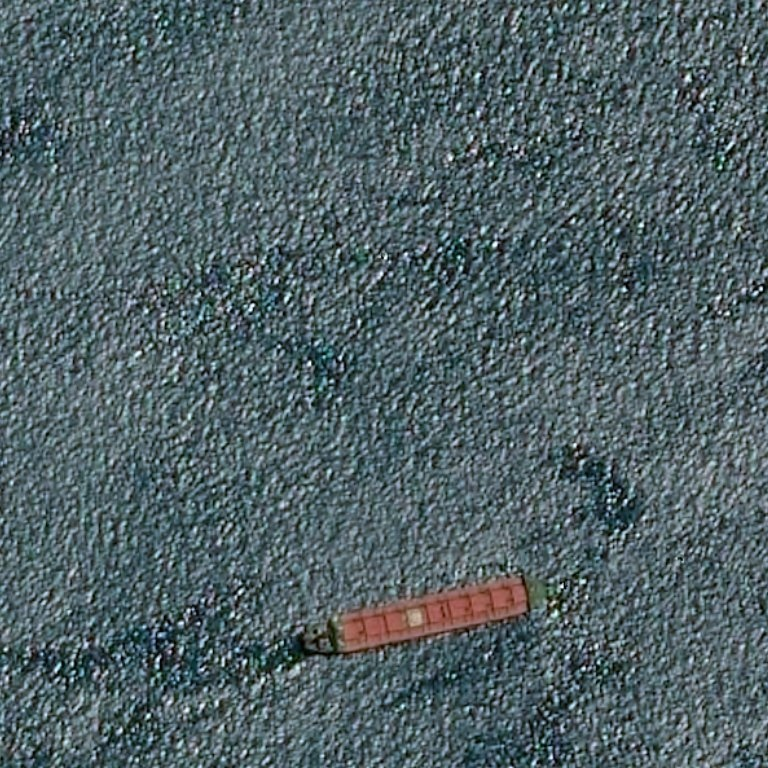

In [5]:
#display an image
display(Image(filename=input_img_paths[5]))

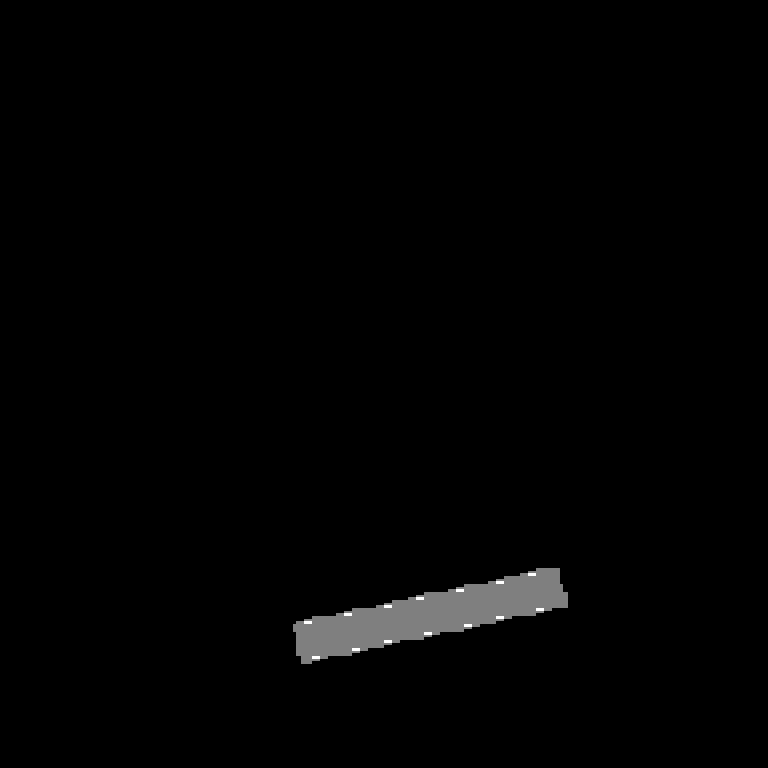

In [6]:
# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[5]))
display(img)

In [7]:
class AirbusShips(keras.utils.Sequence):
    '''Helper to iterate over the data (as Numpy arrays).'''
    
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        '''Return tupe (input, target) correspond to batch #idx.'''
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size = self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
        for j,path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [8]:
from tensorflow.keras import layers

In [9]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 768, 768, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 384, 384, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 384, 384, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 384, 384, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Set aside a validation split

In [10]:
import random

#split our img paths into a training and a validaiton set
val_samples = 200
random.Random(27).shuffle(input_img_paths)
random.Random(27).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

#Instantiate data sequences for each split
train_gen = AirbusShips(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = AirbusShips(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/5
399/399 [==============================] - 2956s 7s/step - loss: 0.0000e+00 - accuracy: 0.2711 - val_loss: 1682.4403 - val_accuracy: 2.1856e-04
Epoch 2/5
399/399 [==============================] - 3125s 8s/step - loss: 0.0000e+00 - accuracy: 0.2735 - val_loss: 1924.4214 - val_accuracy: 0.3285
Epoch 3/5
399/399 [==============================] - 3345s 8s/step - loss: 0.0000e+00 - accuracy: 0.2761 - val_loss: 2065.3057 - val_accuracy: 0.3462
Epoch 4/5
399/399 [==============================] - 3159s 8s/step - loss: 0.0000e+00 - accuracy: 0.2736 - val_loss: 2079.4150 - val_accuracy: 0.3608
Epoch 5/5
399/399 [==============================] - 2882s 7s/step - loss: 0.0000e+00 - accuracy: 0.2714 - val_loss: 2039.1160 - val_accuracy: 0.3421


## That did pretty good so I'm gonna train it for 5 more epochs. I'd better start saving history, too

In [16]:
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/5
399/399 [==============================] - 2881s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2225.5186 - val_accuracy: 0.3683
Epoch 2/5
399/399 [==============================] - 2893s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 1956.7411 - val_accuracy: 0.3371
Epoch 3/5
399/399 [==============================] - 2885s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2161.3406 - val_accuracy: 0.3864
Epoch 4/5
399/399 [==============================] - 2885s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2031.9045 - val_accuracy: 0.3347
Epoch 5/5
399/399 [==============================] - 2871s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 1993.0970 - val_accuracy: 0.3478


In [14]:
#loading saved model
model = get_model(img_size, num_classes)
model.load_weights('model1.h5')

In [19]:
#train for 15 more epochs
epochs=15
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
399/399 [==============================] - 2697s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2127.3645 - val_accuracy: 0.3552
Epoch 2/15
399/399 [==============================] - 2860s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2089.4099 - val_accuracy: 0.3687
Epoch 3/15
399/399 [==============================] - 2849s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2108.6885 - val_accuracy: 0.3479
Epoch 4/15
399/399 [==============================] - 2852s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 1988.6143 - val_accuracy: 0.3544
Epoch 5/15
399/399 [==============================] - 2849s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2122.8027 - val_accuracy: 0.3652
Epoch 6/15
399/399 [==============================] - 2846s 7s/step - loss: 0.0000e+00 - accuracy: 0.2724 - val_loss: 2121.7310 - val_accuracy: 0.3645
Epoch 7/15
399/399 [==============================] - 2845s 7s/step - loss: 0.0000e+00 - accur

In [20]:
epochs = 5
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/5
199/199 [==============================] - 3058s 15s/step - loss: 0.0000e+00 - val_loss: 561.4518
Epoch 2/5
199/199 [==============================] - 3045s 15s/step - loss: 0.0000e+00 - val_loss: 963.2239
Epoch 3/5
199/199 [==============================] - 3045s 15s/step - loss: 0.0000e+00 - val_loss: 1714.0955
Epoch 4/5
199/199 [==============================] - 3008s 15s/step - loss: 0.0000e+00 - val_loss: 1813.9984
Epoch 5/5
199/199 [==============================] - 3011s 15s/step - loss: 0.0000e+00 - val_loss: 1911.9988


In [24]:
model.save('model.h5')

In [20]:
# Generate predictions for all images in the validation set

val_gen = AirbusShips(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

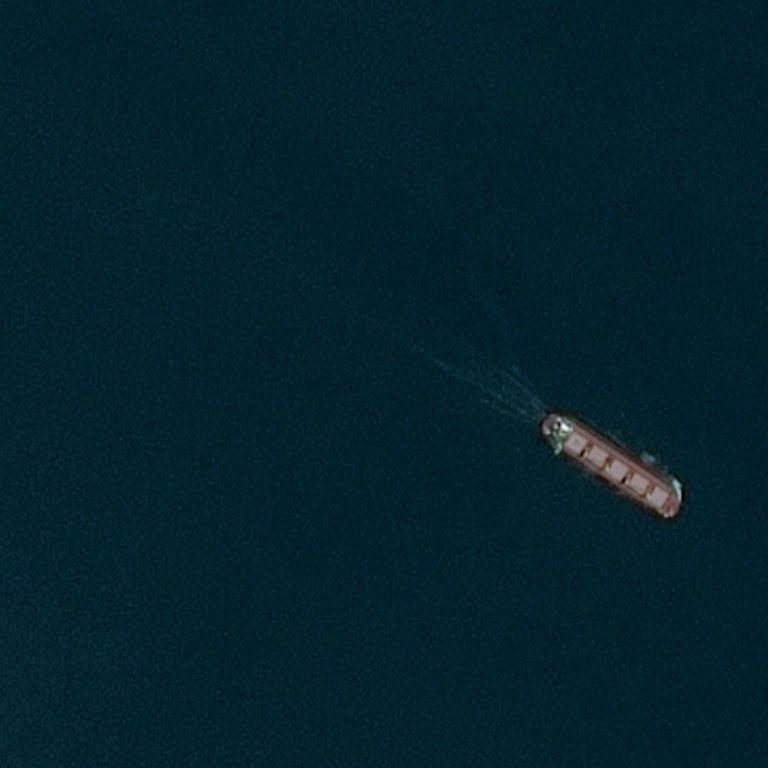

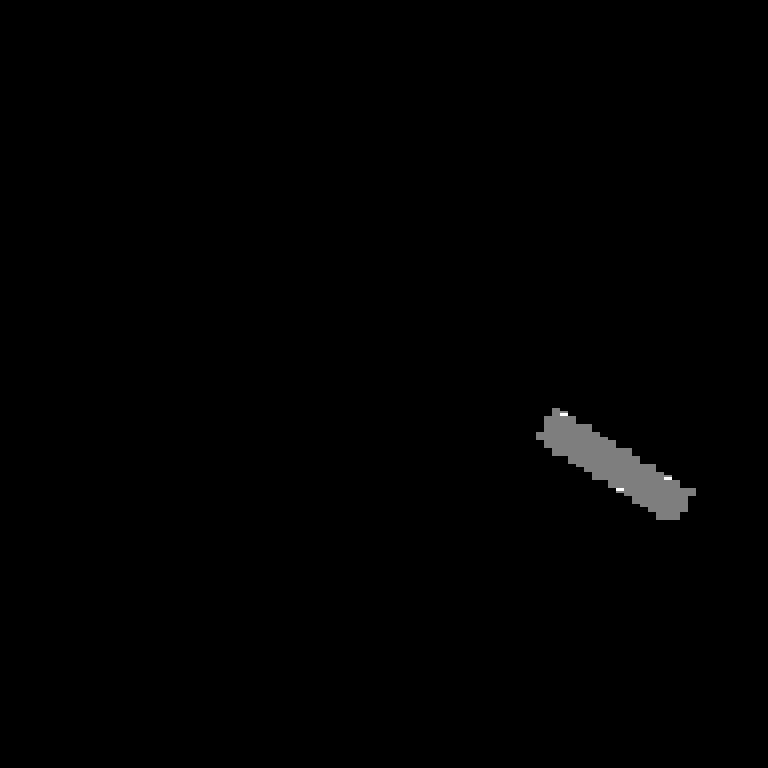

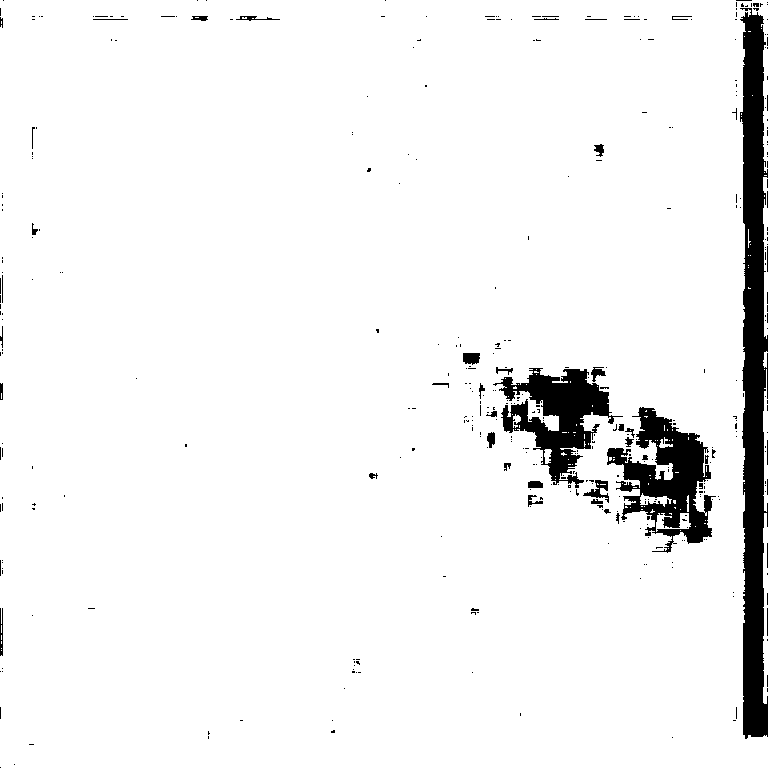

In [34]:
# Display results for validation image #10
i = 25

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.